In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def plot_img(img):
    plt.figure(figsize=(10,7))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
part1_single_objects = "../COTSDataset/Part 1 - Single Objects"
part2_multiple_objects = "../COTSDataset/Part 2 - Multiple Objects"
part3_complex_background = "../COTSDataset/Part 3 - Complex Background"

In [4]:
img_path = os.path.join(part2_multiple_objects, "academic_book_no", "1_colour.jpeg")
# img_path = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_7_mask.png")
# mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_8_mask.png")
mask = cv2.imread(mask_path)

In [5]:
# Extracting target bounding box from mask
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = mask.astype(np.uint8)
# Find contours in the mask
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize an empty list to store bounding boxes
bounding_boxes = []

# Loop through the detected contours
for cnt in contours:
    # Get the bounding box for each contour
    x, y, w, h = cv2.boundingRect(cnt)
    
    # Add the bounding box coordinates to the list
    bounding_boxes.append((x, y, x + w, y + h))

# Find the minimum and maximum coordinates to create a bounding box around all masks
x1, y1 = min(box[0] for box in bounding_boxes), min(box[1] for box in bounding_boxes)
x2, y2 = max(box[2] for box in bounding_boxes), max(box[3] for box in bounding_boxes)

# Create the target bounding box that encompasses all masks
target_bbox = np.array([x1, y1, x2, y2])

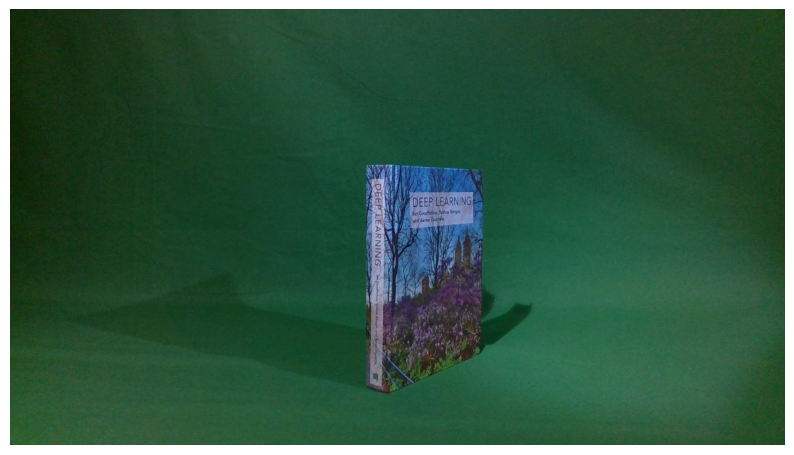

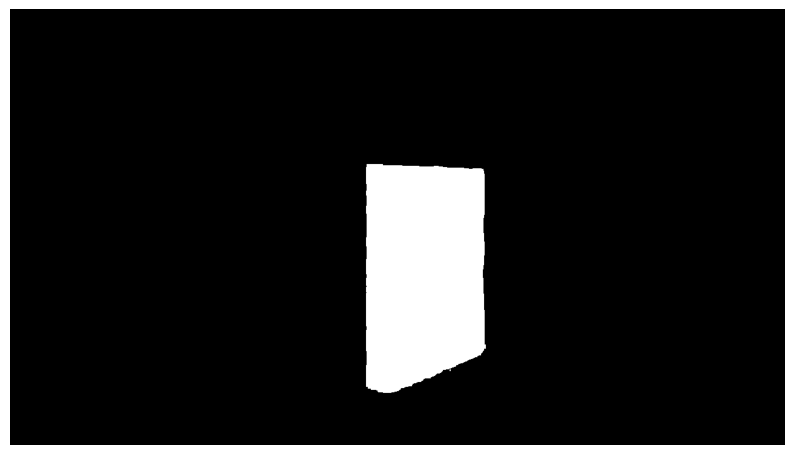

In [6]:
plot_img(img)
plot_img(mask)

In [7]:
from utils import *
from models import *
from env import *
from init import *
from agent import DQNAgent

CUDA is available! Using GPU for computations.


In [8]:
env = gym.make('DetectionEnv-v0', image = img, original_image = img, target_bbox = target_bbox)
_ = env.reset()
# PROBLEM WITH RENDERING

In [9]:
# Creating the environment
# env = DetectionEnv(img, img, target_bbox) #, feature_extractor=ResNet50FeatureExtractor(), target_size=RESNET50_TARGET_SIZE)
# env = gym.make('DetectionEnv-v0', image = img, original_image = img, target_bbox = target_bbox, feature_extractor=ResNet50FeatureExtractor(), target_size=RESNET50_TARGET_SIZE)
# _ = env.reset()

In [10]:
# env = DetectionEnv(img, img, target_bbox, feature_extractor=MobileNetV2FeatureExtractor(), target_size=MOBILENETV2_TARGET_SIZE)
# env = gym.make('DetectionEnv-v0', image = img, original_image = img, target_bbox = target_bbox, feature_extractor=MobileNetV2FeatureExtractor(), target_size=MOBILENETV2_TARGET_SIZE)
# _ = env.reset()

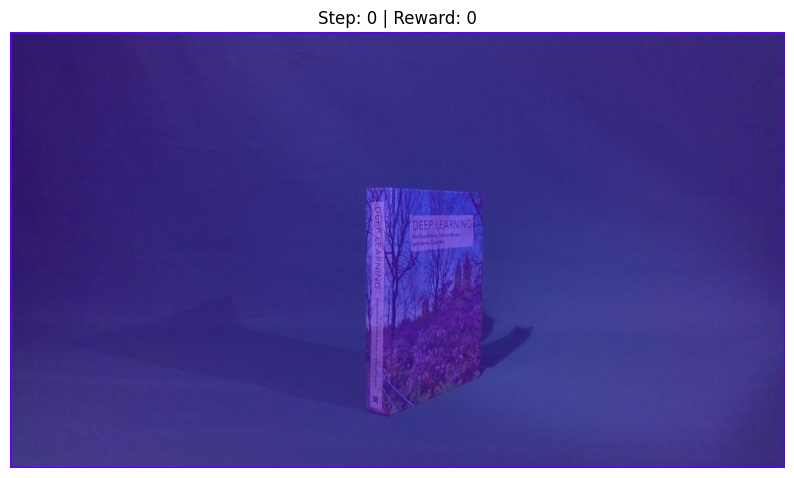

In [11]:
frame = env.display(do_display=True)

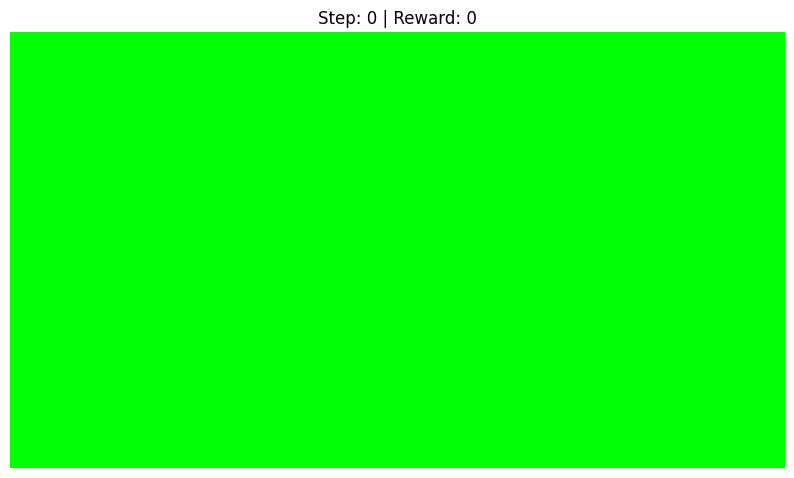

In [12]:
frame = env.display(do_display=True, mode='bbox')

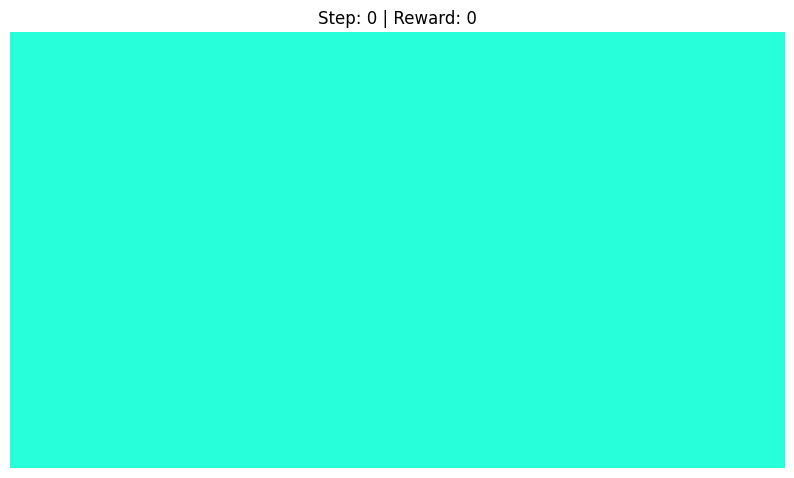

In [13]:
frame = env.display(do_display=True, mode='heatmap')

In [14]:
env.get_actions()

Actions:
0: Move right → 
1: Move left ←
2: Move up ↑
3: Move down ↓
4: Make bigger +
5: Make smaller -
6: Make fatter W
7: Make taller H
8: Trigger T


In [15]:
observation_space, info = env.reset()
print(observation_space)

tensor([[0.0000e+00, 3.4892e-02, 1.2909e-02,  ..., 1.0000e+02, 1.0000e+02,
         1.0000e+02]])


In [16]:
env.observation_space

Box(0.0, 100.0, (2138,), float32)

Action: Make bigger +
Terminated:  False
Truncated:  False
Reward:  -1
IoU 0.2922073903658053
Recall 0.6443358136473459


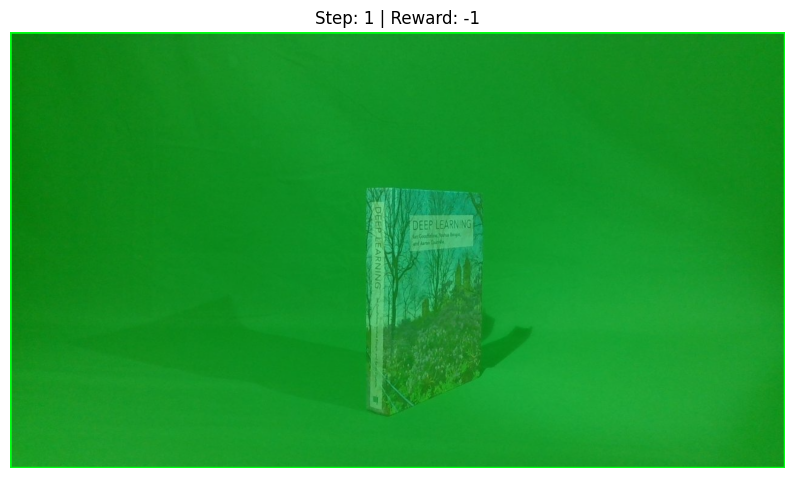

In [17]:
action = env.action_space.sample()

env.decode_action(action)

# Taking a step in the environment
next_state, reward, terminated, truncated, info = env.step(action)
print("Terminated: ", terminated)
print("Truncated: ", truncated)
print("Reward: ", reward)
print("IoU", info['iou'])
print("Recall", info['recall'])
_ = env.display(do_display=True, mode='image')

In [18]:
img_path2 = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
# img_path = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
img2 = cv2.imread(img_path2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

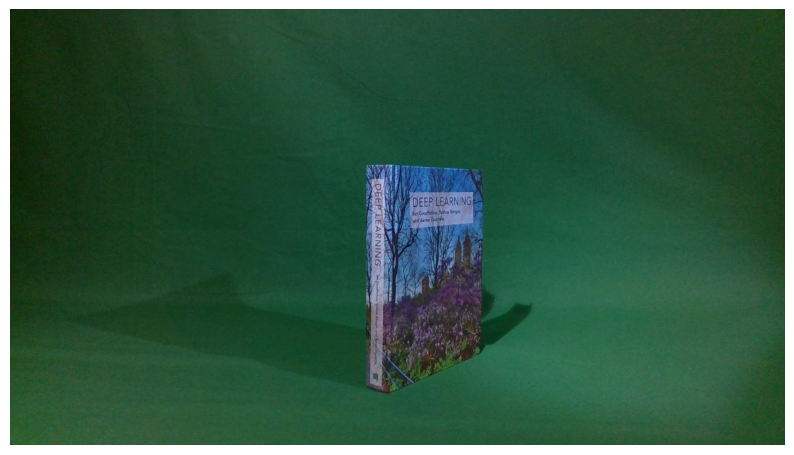

In [19]:
plot_img(img)

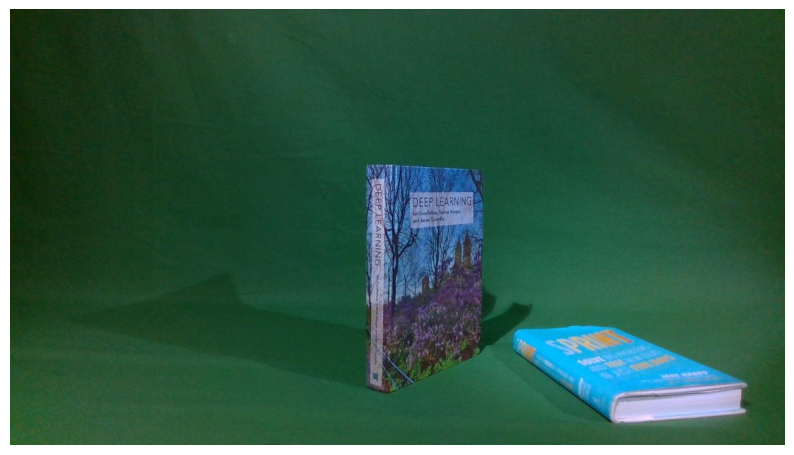

In [20]:
plot_img(img2)

In [21]:
def check(image1, image2):
    for i in range(len(image1)):
        for j in range(len(image1[0])):
            if image1[i][j] != image2[i][j]:
                print("Not equal")
                break

In [22]:
image1, _ = env.reset(image=img)
image2, _ = env.reset(image=img2)
check(image1, image2)

Not equal


In [23]:
image1, _ = env.reset(image=img)
image2, _ = env.reset(image=img)
check(image1, image2)

In [24]:
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
save_path ="DQN_model1"
agent = DQNAgent(input_size, output_size, save_path=save_path)

In [25]:
# Training the agent
num_episodes = 1000
rewards_list = []
iou_list = []
recall_list = []

for episode in range(num_episodes):
    env.reset()
    state = env.get_state()
    state = state  # Move the state tensor to CUDA if available
    total_reward = 0
    # agent.reset()
    
    print("Epsilon: ", agent.epsilon)

    counter = 0
    while True:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        # print("Truncated: ", truncated)
        done = truncated or terminated
        next_state = torch.Tensor(next_state).view(1, -1)  # Convert the next_state to a PyTorch tensor and move to CUDA if available
        total_reward += reward

        # Ensure all tensors used in replay buffer are on the CUDA device
        agent.replay_buffer.push(Transition(state, action, reward, done, next_state))

        state = next_state
        agent.update()

        counter += 1
        if done:
            break

    # agent.update_epsilon()

    rewards_list.append(total_reward)
    iou_list.append(info['iou'])
    recall_list.append(info['recall'])
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, IoU: {info['iou']}, Recall: {info['recall']}, Steps: {env.step_count}, Threshold: {info['threshold']}")

Epsilon:  1.0
Episode 1/1000, Total Reward: -11.0, IoU: 0.266290832303156, Recall: 0.444369526653342, Steps: 6, Threshold: 0.4
Epsilon:  1.0
Episode 2/1000, Total Reward: 8.562818544106918, IoU: 0.6562818544106918, Recall: 1.0, Steps: 7, Threshold: 0.4
Epsilon:  1.0
Episode 3/1000, Total Reward: -9.0, IoU: 0.3016555706121487, Recall: 0.410977596904825, Steps: 6, Threshold: 0.4
Epsilon:  1.0
Episode 4/1000, Total Reward: -12.0, IoU: 0.09641475524688538, Recall: 0.1587922716947207, Steps: 5, Threshold: 0.4
Epsilon:  1.0
Episode 5/1000, Total Reward: 5.278854706309707, IoU: 0.5278854706309707, Recall: 0.6240718889718336, Steps: 17, Threshold: 0.4
Epsilon:  1.0
Episode 6/1000, Total Reward: -12.0, IoU: 0.3374059568749834, Recall: 0.6126937494481502, Steps: 17, Threshold: 0.4
Epsilon:  1.0
Episode 7/1000, Total Reward: -11.0, IoU: 0.21834732843997617, Recall: 0.444369526653342, Steps: 2, Threshold: 0.4
Epsilon:  1.0
Episode 8/1000, Total Reward: -10.0, IoU: 0.32550146335623664, Recall: 0.41

In [26]:
# from stable_baselines3 import DQN

# model = DQN("MlpPolicy", env, verbose=1)
# obs, info = env.reset()

# # Train the model for a certain number of time steps
# total_timesteps = 10000
# update_frequency = 4  # Update the model every 4 steps
# for timestep in range(total_timesteps):
#     print(f"Timestep {timestep + 1}/{total_timesteps}")
#     print(obs)
#     obs_np = obs.detach().numpy()
#     action, _states = model.predict(obs_np, deterministic=True)
#     obs, reward, terminated, truncated, info = env.step(action[0])
    
#     # Incrementally train the model
#     if timestep % update_frequency == 0:
#         obs_np = obs.detach().numpy()
#         model.learn(obs_np, action, reward, obs_np, terminated)  # Update the model using a single step of experience

#     if terminated or truncated:
#         obs, info = env.reset()


In [27]:
# obs, info = env.reset()
# while True:
#     obs = obs.detach().numpy()
#     action, _states = model.predict(obs, deterministic=True)
#     print(action[0])
#     obs, reward, terminated, truncated, info = env.step(action[0])
#     if terminated or truncated:
#         obs, info = env.reset()

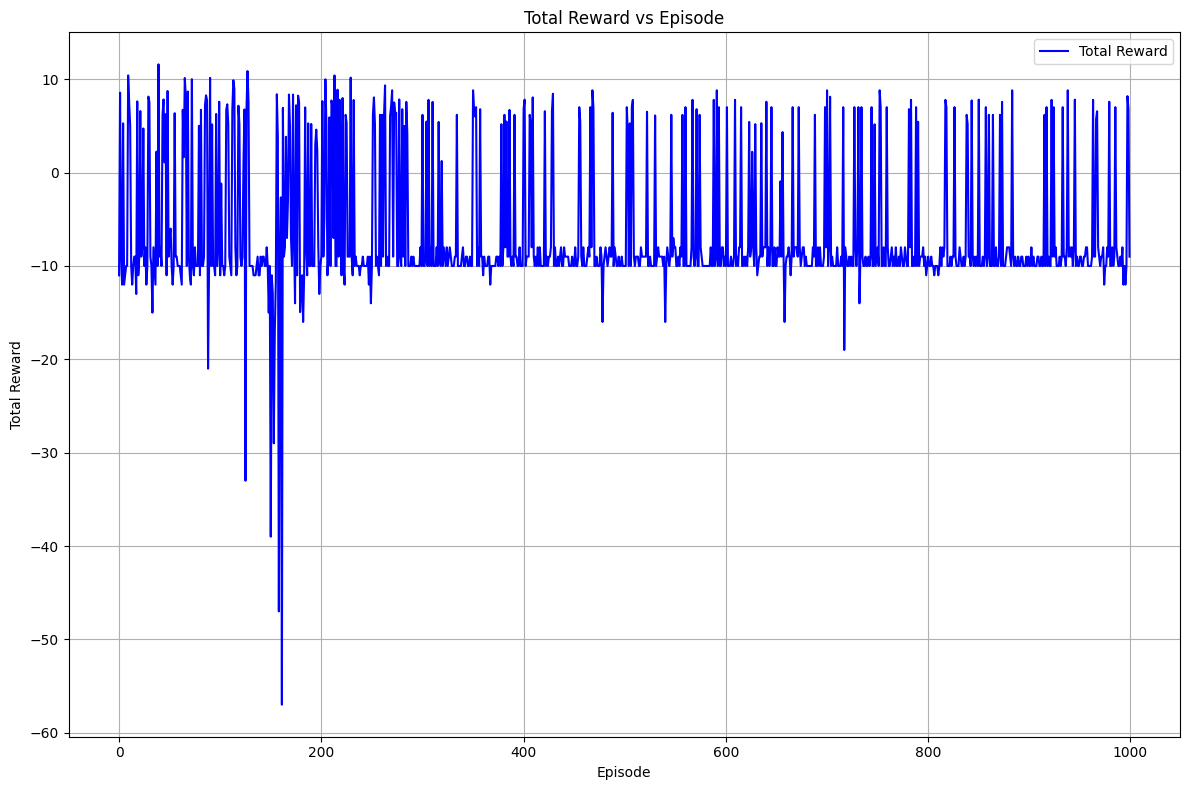

In [34]:
# Plotting the rewards
plt.figure(figsize=(12,8))
plt.plot(rewards_list, label='Total Reward', color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

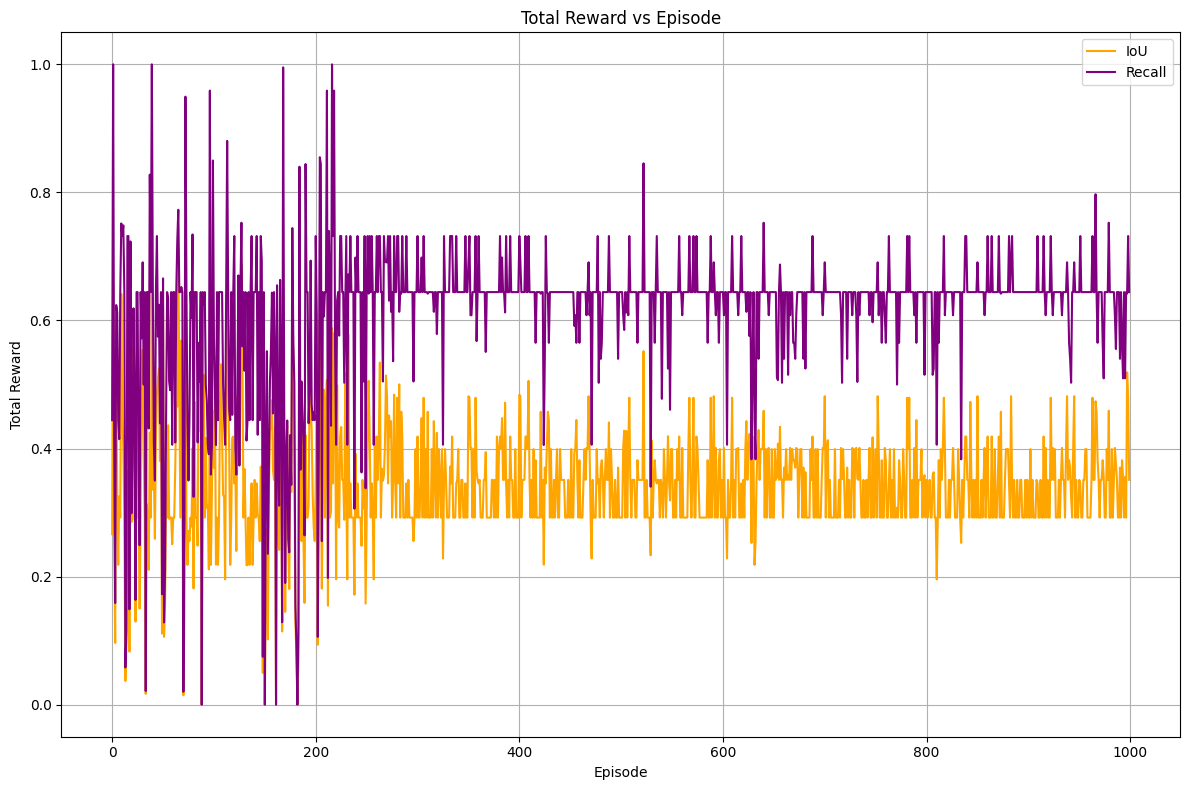

In [33]:
plt.figure(figsize=(12,8))
plt.plot(iou_list, label='IoU', color='orange')
plt.plot(recall_list, label='Recall', color='purple')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

Action: Make fatter W


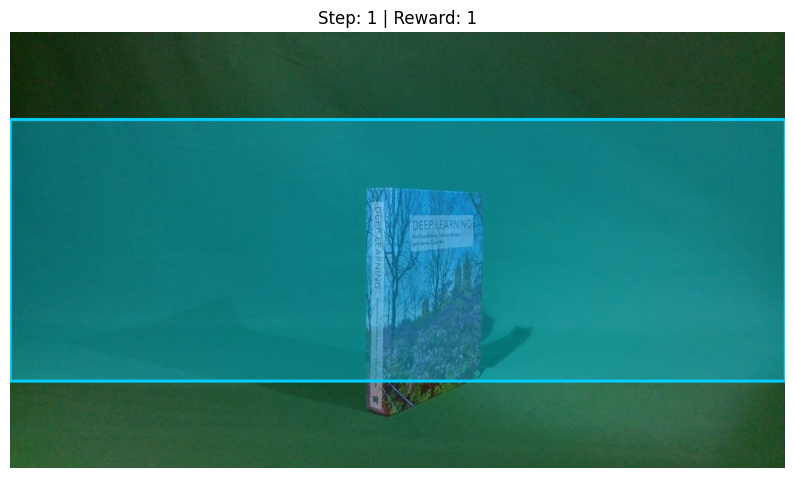

Action: Trigger T


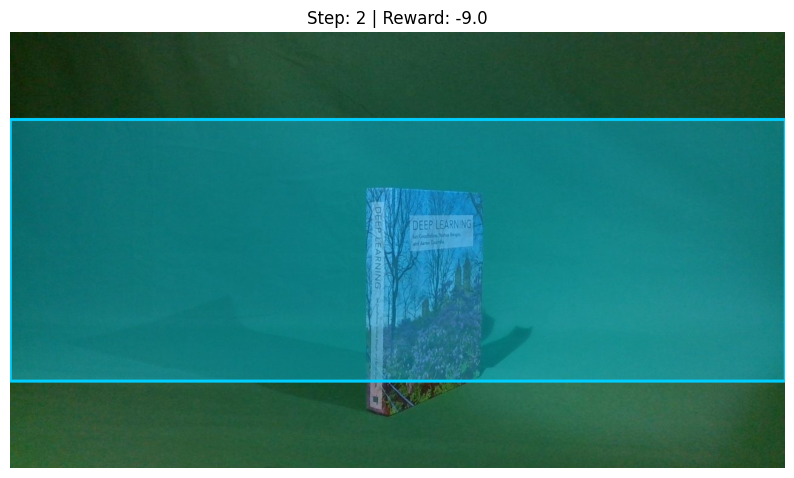

Total Reward: 0, IoU: 0.35110156629298994, Recall: 0.6443358136473459, Steps: 2


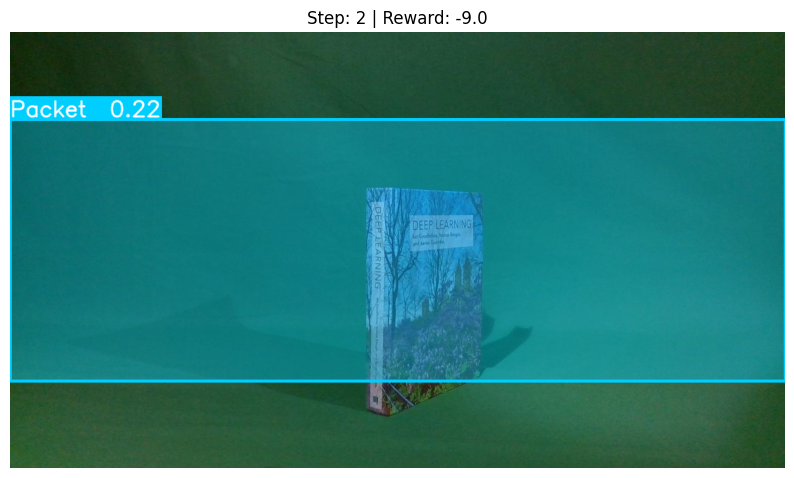

In [32]:
# Predicting the bounding box
env.reset()
state = env.get_state()
state = state.to(device)  # Move the state tensor to CUDA if available
total_reward = 0
agent.reset()
terminated = False
truncated = False

while True:
    action = agent.select_action(state)
    next_state, _, terminated, truncated, info = env.step(action)
    env.decode_action(action)
    done = truncated or terminated
    next_state = torch.Tensor(next_state).view(1, -1).to(device)  # Convert the next_state to a PyTorch tensor and move to CUDA if available

    state = next_state

    env.display(do_display=True, mode='image')
    if done:
        break

print(f"Total Reward: {total_reward}, IoU: {info['iou']}, Recall: {info['recall']}, Steps: {env.step_count}")
env.predict()